# 연구목적에 따라 Recall, Precision 등을 최대화 하기 위한 방법
## 교차검증과 hyperparameter를 통해 최적화
- 튜닝이외 방법론으로는 의사결정값(cut-off value)를 선택하여 recall과 precision을 조정

In [24]:
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.metrics import auc, make_scorer, recall_score, precision_score, confusion_matrix, classification_report

import matplotlib.pyplot as plt
plt.style.use("ggplot")

import warnings
warnings.filterwarnings("ignore")
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from IPython.display import HTML
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

## 1. scikit-learn metrics, make_scorer()

- The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives.
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html
- The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives.
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html

In [2]:
from sklearn.metrics import (recall_score, precision_score)
y_true = [0, 1, 0, 0, 0, 0]
y_pred = [1, 1, 1, 0, 1, 1]
recall_score(y_true, y_pred)
precision_score(y_true, y_pred)

1.0

0.2

In [3]:
y_true = ['dog', 'cat', 'dog', 'dog', 'dog']
y_pred = ['dog', 'cat', 'dog', 'cat', 'dog'] 
recall_score(y_true, y_pred, pos_label='cat')
recall_score(y_true, y_pred, pos_label='dog')

1.0

0.75

In [4]:
import sklearn
sorted(sklearn.metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_weighted',
 'v_measure_score']

In [4]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import fbeta_score, make_scorer, accuracy_score
from sklearn.tree import DecisionTreeClassifier

## 이진분류 가상데이터 생성

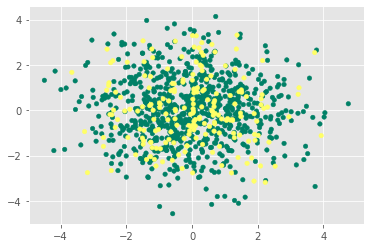

In [5]:
from sklearn.datasets import make_blobs
n_samples_1 = 800; n_samples_2 = 200 
centers = [[0.0, 0.0], [0.0, 0.0]]; clusters_std = [1.5, 1.5]
X, y = make_blobs(n_samples=[n_samples_1, n_samples_2], centers=centers,
                  cluster_std=clusters_std, random_state=0, shuffle=False)
plt.scatter(X[:, 0], X[:, 1], c=y, s=20, cmap='summer')

## make_scorer(fbeta_score, beta=1),make_scorer(recall_score) 등으로 변경하여 classification report를 확인

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y)
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

scorer = make_scorer(fbeta_score, beta=2) # 
#scorer = make_scorer(recall_score)

print(scorer(model, X_test, y_test))

from sklearn.metrics import classification_report
y_predict = model.predict(X_test)
print(classification_report(y_test, y_predict))

DecisionTreeClassifier(random_state=42)

0.24444444444444446
              precision    recall  f1-score   support

           0       0.83      0.85      0.84       204
           1       0.27      0.24      0.25        46

    accuracy                           0.74       250
   macro avg       0.55      0.55      0.55       250
weighted avg       0.73      0.74      0.73       250



## gridsearch와 cross validation으로 복수의 성능지표를 비교할 경우
### 방법1 사전형

In [7]:
scoring = {'Recall': 'recall', 'Precision': 'precision'} 

### 방법 2 리스트형

In [8]:
scoring = ['accuracy', 'precision'] 

### 방법 3 make_score() 함수 사용

In [9]:
scoring = {'F1':make_scorer(fbeta_score, beta=1), 'F2':make_scorer(fbeta_score, beta=2)} 

여러 개의 metrics를 설정하면 교차검증과 하이퍼파라미터를 각각 수행하여 결과를 보여 줌

In [10]:
scoring = {'Recall': 'recall', 'Precision': make_scorer(precision_score)}

In [11]:
scoring = {'Accuracy': make_scorer(accuracy_score), 'F1' : 'f1'}

### Refit(refit='single metric')명령어로 훈련데이터를 마지막으로 학습

In [12]:
gs = GridSearchCV(DecisionTreeClassifier(random_state=42),
                  param_grid={'min_samples_split': range(2, 50, 10)},
                  
                  scoring=scoring, 
                  
                  cv=2,
                  refit= 'F1')

gs.fit(X_train, y_train)
pd.DataFrame(gs.cv_results_).iloc[:, [5,8,10, 13,15]]
gs.best_estimator_
gs.best_score_

GridSearchCV(cv=2, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'min_samples_split': range(2, 50, 10)}, refit='F1',
             scoring={'Accuracy': make_scorer(accuracy_score), 'F1': 'f1'})

,params,mean_test_Accuracy,rank_test_Accuracy,mean_test_F1,rank_test_F1
0,{'min_samples_split': 2},0.710667,5,0.192167,1
1,{'min_samples_split': 12},0.712000,4,0.181912,2
2,{'min_samples_split': 22},0.746667,3,0.150700,4
3,{'min_samples_split': 32},0.752000,2,0.153431,3
4,{'min_samples_split': 42},0.780000,1,0.127260,5


DecisionTreeClassifier(random_state=42)

0.19216666666666665

## GridSearchCV and scoring을 통해 최적화

In [13]:
clf = RandomForestClassifier()

param_grid = {
    'min_samples_split': [3, 5, 10], 
    'n_estimators' : [100, 300],
    'max_depth': [3, 5, 15, 25]
}

- `scorers` dictionary는 `GridSearchCV`의 `scoring` 인자로 작용
- `GridSearchCV.cv_results_`는 모든 scoring 점수를 생성 

In [14]:
scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score)
}

- `scorers`를 기준으로 교차검증과 튜닝으로 최적의 모델(score가 가장 높은)을 찾은 후에 `refit`인자로 마지막으로 훈련데이터(X_train)를 학습완료 
- 사용자 정의함수를 사용하여 3가지 scorers를 기준으로 각각 훈련과 예측을 하여 결과를 비교(재사용)

In [15]:
def grid_search_wrapper(refit_score='precision_score'):

    kf = KFold(n_splits=3)
    grid_search = RandomizedSearchCV(clf, param_grid, 
                               
                               scoring=scorers, 
                               
                               cv=kf, 
                               
                               return_train_score=True, 
                               
                               refit=refit_score)
    
    grid_search.fit(X_train, y_train)

    # make the predictions
    y_pred = grid_search.predict(X_test)

    print('Best params for {}'.format(refit_score))
    print(grid_search.best_params_)

    # confusion matrix on the test data.
    print('\nConfusion matrix of Random Forest optimized for {} on the test data:'.format(refit_score))
    print(pd.DataFrame(confusion_matrix(y_test, y_pred),
                 columns=['음성판정', '양성판정'], index=['음성(실제)', '양성(실제)']))
    
    return grid_search

### 최고의 precision을 갖는 classifer가 refit

In [16]:
grid_search_clf = grid_search_wrapper(refit_score='precision_score')

Best params for precision_score
{'n_estimators': 100, 'min_samples_split': 5, 'max_depth': 15}

Confusion matrix of Random Forest optimized for precision_score on the test data:
        음성판정  양성판정
음성(실제)   193     3
양성(실제)    54     0


`param_grid`의 모든 하이퍼파라미터에 대한 'precision', 'recall', 'accuracy' 점수를 생성하여 `cv_results_`에 저장

In [17]:
results = pd.DataFrame(grid_search_clf.cv_results_)
results = results.sort_values(by='mean_test_precision_score', ascending=False)
results[['mean_test_precision_score', 'mean_test_recall_score', 'mean_test_accuracy_score',
         'param_max_depth', 'param_min_samples_split',
         'param_n_estimators']].head()

,mean_test_precision_score,mean_test_recall_score,mean_test_accuracy_score,param_max_depth,param_min_samples_split,param_n_estimators
3,0.215456,0.047246,0.773333,15,5,100
9,0.166667,0.026667,0.774667,15,3,300
0,0.134921,0.013333,0.781333,25,10,300
4,0.111111,0.006667,0.786667,15,10,300
6,0.108333,0.013913,0.782667,25,10,100


### 최고의 recall을 갖는 classifer가 refit
  <font color='red'> 참양성율(TPR, recall, 검측율, 재현율, sensitivity)이 증가하게 됨

In [18]:
grid_search_clf = grid_search_wrapper(refit_score='recall_score')

Best params for recall_score
{'n_estimators': 100, 'min_samples_split': 3, 'max_depth': 25}

Confusion matrix of Random Forest optimized for recall_score on the test data:
        음성판정  양성판정
음성(실제)   191     5
양성(실제)    51     3


In [19]:
results = pd.DataFrame(grid_search_clf.cv_results_)
results = results.sort_values(by='mean_test_recall_score', ascending=False)
results[['mean_test_precision_score', 'mean_test_recall_score', 'mean_test_accuracy_score',
         'param_max_depth', 'param_min_samples_split',
         'param_n_estimators']].head()

,mean_test_precision_score,mean_test_recall_score,mean_test_accuracy_score,param_max_depth,param_min_samples_split,param_n_estimators
8,0.187121,0.054493,0.762667,25,3,100
2,0.212121,0.040000,0.768000,15,3,300
9,0.203704,0.026667,0.774667,15,5,300
0,0.000000,0.000000,0.804000,5,5,100
1,0.000000,0.000000,0.805333,3,3,300


## Multi-Class metrics
- 'micro': Calculate metrics globally by counting the total true positives, false negatives and false positives.
- 'macro': Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.
- 'weighted': Calculate metrics for each label, and find their average weighted by support (the number of true instances for each label). This alters ‘macro’ to account for label imbalance; it can result in an F-score that is not between precision and recall.

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html

In [56]:
from sklearn.metrics import recall_score, precision_score
y_true = [0, 1, 2, 0, 1, 2, 1, 1, 0, 0]
y_pred = [0, 2, 1, 0, 0, 1, 1, 1, 1, 2]
recall_score(y_true, y_pred, average='macro')
recall_score(y_true, y_pred, average='micro')
recall_score(y_true, y_pred, average='weighted')

0.3333333333333333

0.4

0.4

array([0.5, 0.5, 0. ])

array([0.5, 0.5, 0. ])

In [57]:
print(confusion_matrix(y_true, y_pred))
recall_score(y_true, y_pred, average=None)

[[2 1 1]
 [1 2 1]
 [0 2 0]]


array([0.5, 0.5, 0. ])

### precision과 recall 계산식에는 다수 범주유형인 TN은 없음
Recall = TP/(FN+TP), Precsion = TP/(FP+TP)

- Class 0 : 2 TP and 2 FP
- Class 1 : 2 TP and 2 FP
- Class 2 : 0 TP and 2 FP

A average recall_micro : 4/(4+4+2)   = 0.4
A average recall_macro : (0.5 + 0.5 + 0)/3 = 0.33333

In [61]:
precision_score(y_true, y_pred, average='micro')
precision_score(y_true, y_pred, average='macro')
(2/3 + 2/5 + 0/2)/3

0.4

0.35555555555555557

0.35555555555555557

## 100% prediction

In [74]:
y_true = [0, 1, 2, 0, 1, 2, 1, 1, 0, 0]
y_pred = [0, 1, 2, 0, 1, 2, 1, 1, 0, 0]
recall_score(y_true, y_pred, average='macro')
precision_score(y_true, y_pred, average='macro')

1.0

1.0

In [75]:
print(classification_report(y_true, y_pred))
print(confusion_matrix(y_true, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         2

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10

[[4 0 0]
 [0 4 0]
 [0 0 2]]


- The MCC is in essence a correlation coefficient value between -1 and +1. A coefficient of +1 represents a perfect prediction (전체 Class를 고려)
- 0 an average random prediction and -1 an inverse prediction. The statistic is also known as the phi coefficient.
- https://scikit-learn.org/stable/modules/model_evaluation.html#matthews-corrcoef

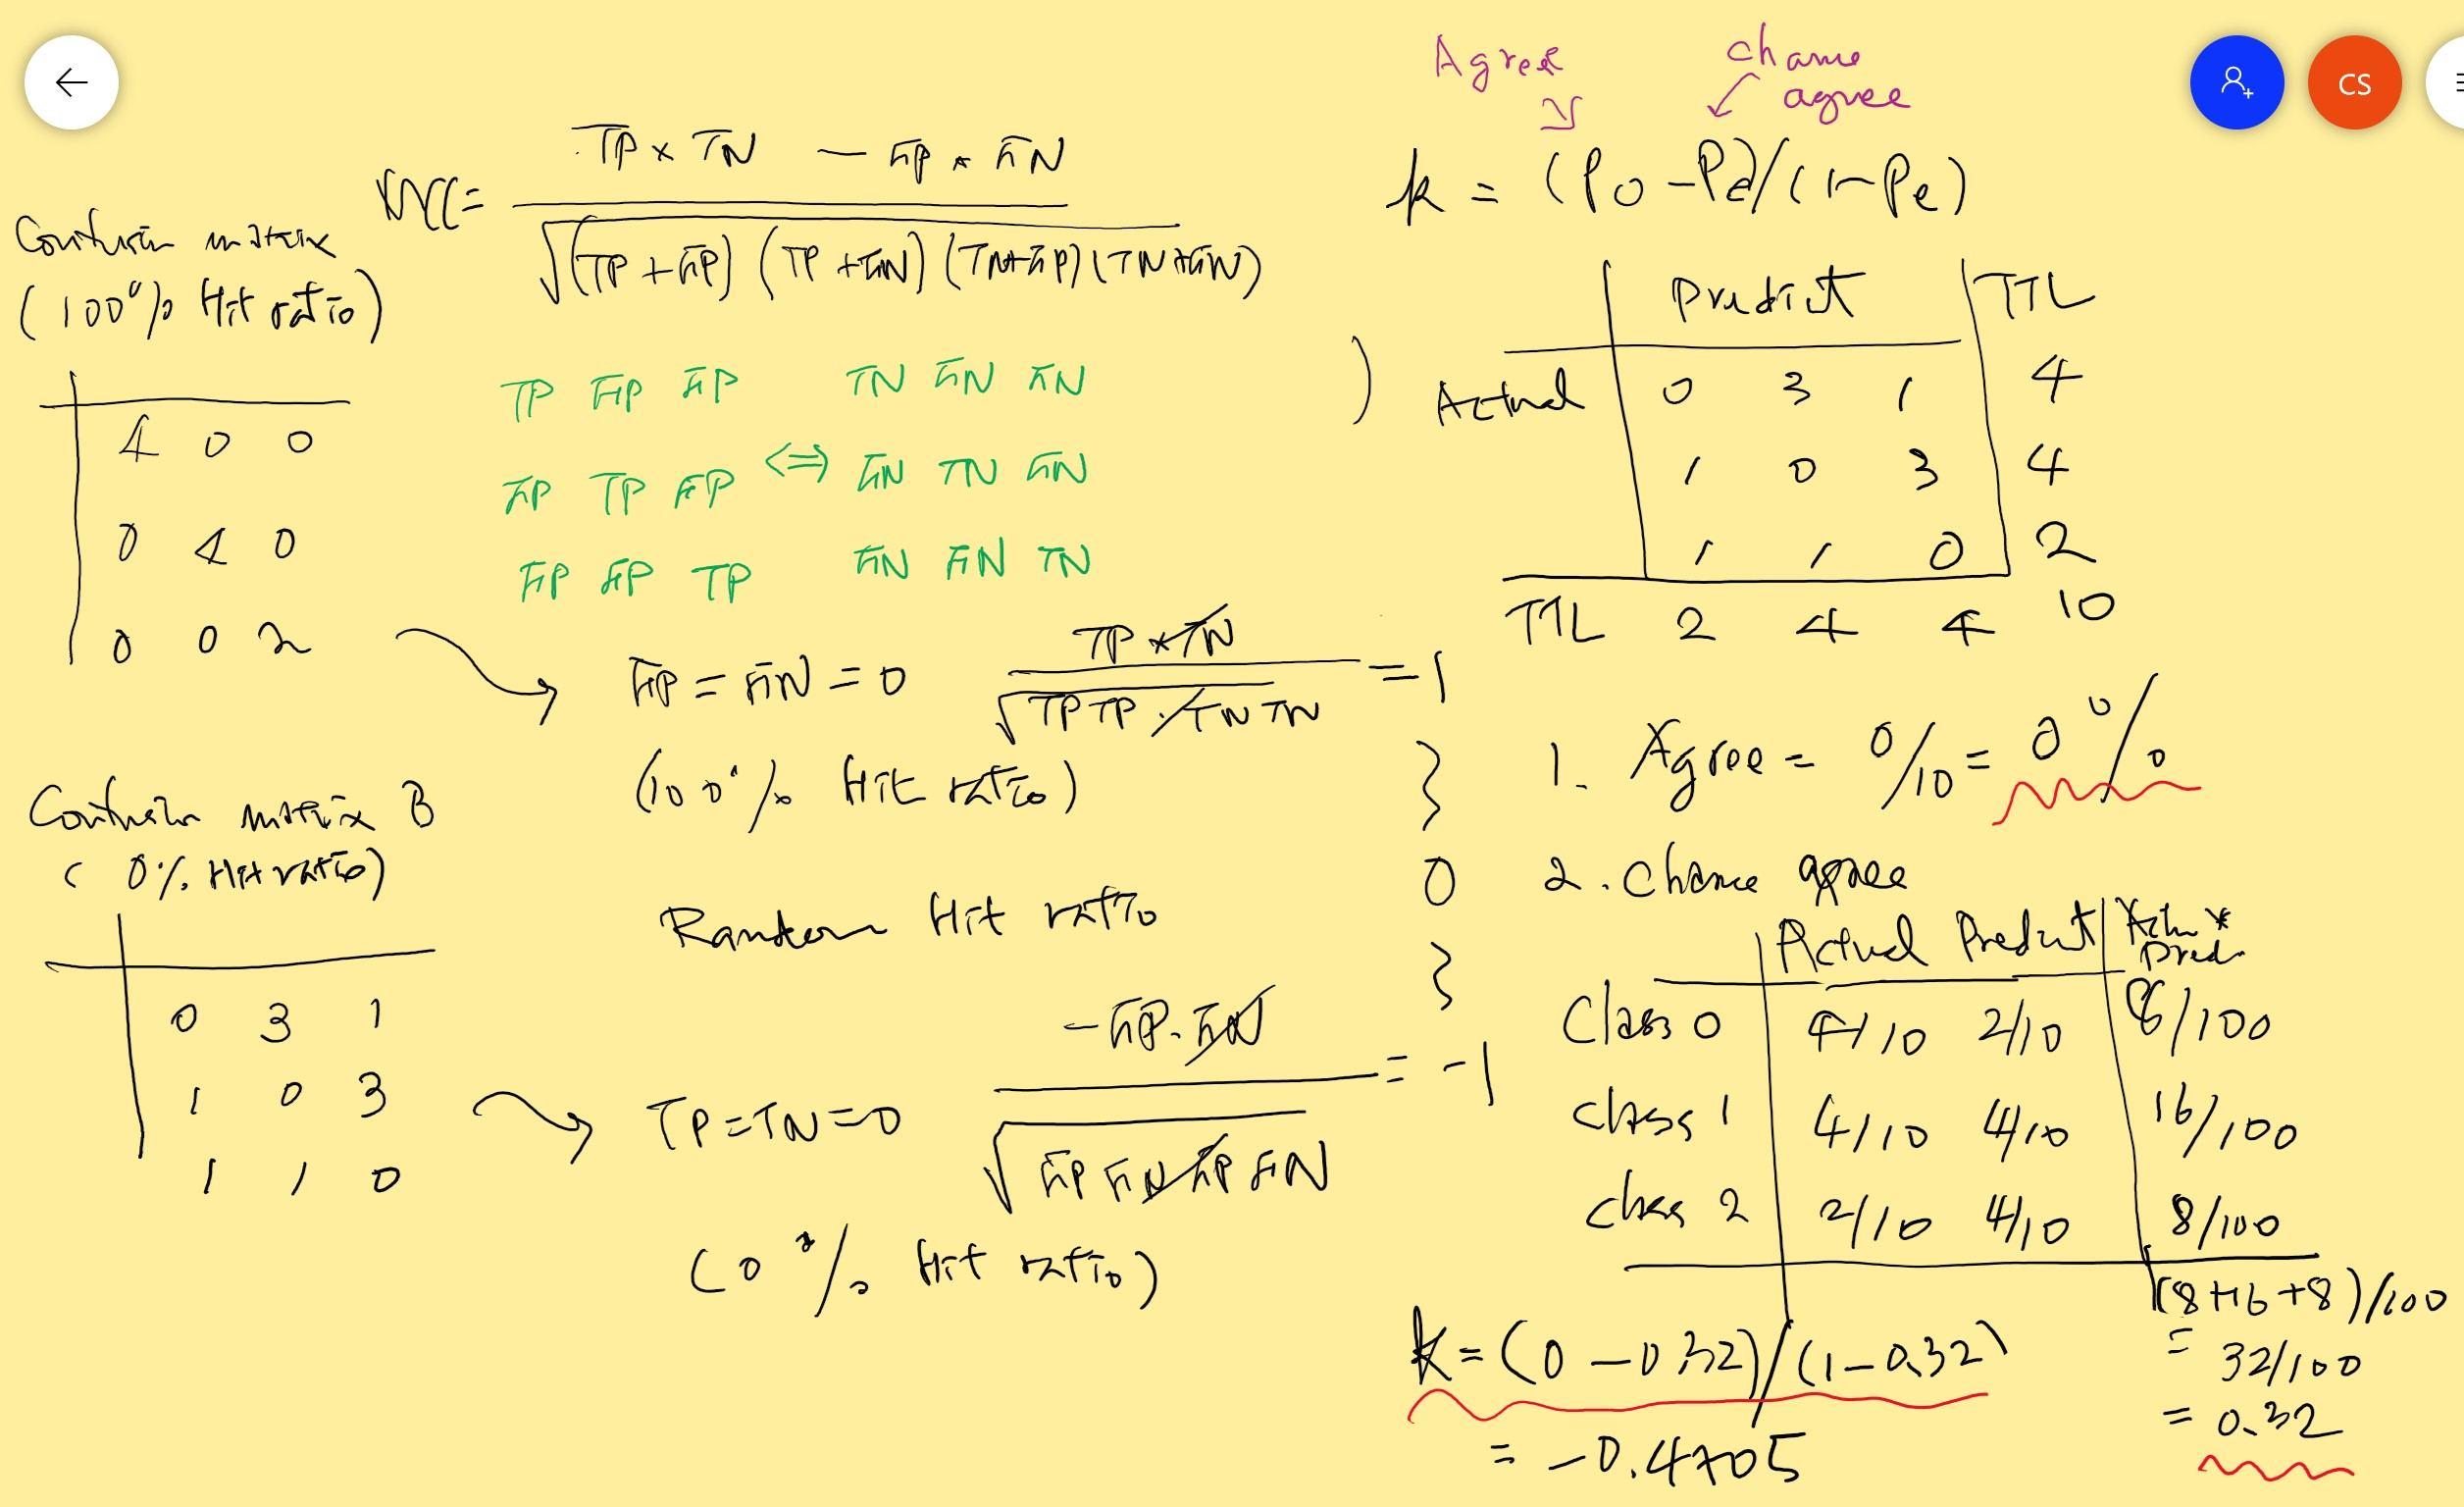

In [82]:
from IPython.display import Image
Image(filename='../image/cv/mcc_kappa.jpg', width=1000, height=700)

In [69]:
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import cohen_kappa_score

matthews_corrcoef(y_true, y_pred)
cohen_kappa_score(y_true, y_pred)

1.0

1.0

## 0% prediction

In [76]:
y_pred = [1, 2, 1, 1, 2, 0, 0, 2, 1, 2]
recall_score(y_true, y_pred, average='macro')
precision_score(y_true, y_pred, average='macro')

0.0

0.0

In [77]:
print(classification_report(y_true, y_pred))
print(confusion_matrix(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       4.0
           1       0.00      0.00      0.00       4.0
           2       0.00      0.00      0.00       2.0

    accuracy                           0.00      10.0
   macro avg       0.00      0.00      0.00      10.0
weighted avg       0.00      0.00      0.00      10.0

[[0 3 1]
 [1 0 3]
 [1 1 0]]


In [80]:
matthews_corrcoef(y_true, y_pred)
cohen_kappa_score(y_true, y_pred)
(0-0.32)/(1-0.32)

-0.5

-0.47058823529411775

-0.4705882352941177

# End